In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install kanjize
!pip install mojimoji
!pip install catboost
!pip install japanize_matplotlib
!pip install category_encoders
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 192.4/192.4 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 41.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for japanize_matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120257 sha256=7acdc973fd4959379212f3e24b9f05f12cb4aa290070c2112970830122a1a0e3
  Stored in directory: /root/.cache/pip/wheels/61/7a/6b/df1f79be9c59862525070e157e62b08eab8ece27c1b68fbb94
Successfully built japanize_matplotlib
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 5.6 MB/s eta 0:00:00


# Import data

In [3]:
import pandas as pd

train_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/train.csv', index_col='id')
test_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/test.csv', index_col='id')
test_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/test.csv', index_col='id')

# Define custom transformer

In [4]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from catboost import CatBoostClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import LabelEncoder
import kanjize
import mojimoji
import re
import numpy as np
import math

class MissingnessIndicatorTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_transformed = X.copy()

        columns_with_nan = X_transformed.columns[X_transformed.isna().any()]
        for column in columns_with_nan:
            X_transformed[column + '_NA'] = np.where(X_transformed[column].isnull(), 1, 0)

        return X_transformed

class LabelEncoderTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, columns=[]):
        self.columns = columns
        self.le = LabelEncoder()

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_transformed = X.copy()
        X_transformed[self.columns] = X_transformed[self.columns].apply(self.le.fit_transform)
        return X_transformed

class ScalerTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, columns=[]):
        self.columns = columns
        self.scaler = MinMaxScaler()

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_transformed = X.copy()
        scaled_df = pd.DataFrame(self.scaler.fit_transform(X_transformed[self.columns]))
        scaled_df.columns = X[self.columns].columns
        scaled_df.index = X[self.columns].index
        X_transformed[self.columns] = scaled_df
        return X_transformed

class ImputerTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, columns=[], strategy='mean'):
        self.columns = columns
        self.imputer = SimpleImputer(strategy=strategy)

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_transformed = X.copy()
        scaled_df = pd.DataFrame(self.imputer.fit_transform(X_transformed[self.columns]))
        scaled_df.columns = X[self.columns].columns
        scaled_df.index = X[self.columns].index
        X_transformed[self.columns] = scaled_df
        return X_transformed

class TextCleanerTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_transformed = X.copy()
        X_transformed['Age'] = X_transformed.Age.map(lambda x: kanjize.kanji2number(x[:-1]) if type(x) != float else x)
        X_transformed['DurationOfPitch'] = X_transformed.DurationOfPitch.map(self.convert_time)
        X_transformed['Gender'] = X_transformed.Gender.map(lambda x: mojimoji.zen_to_han(x).replace(' ', '').lower())
        X_transformed['ProductPitched'] = X_transformed.ProductPitched.map(lambda x: re.sub('\s|\|', '', mojimoji.zen_to_han(x)).lower()).map(self.standarize_text)
        X_transformed['NumberOfTrips'] = X_transformed.NumberOfTrips.map(self.standarize_number_of_trips)
        X_transformed['Designation'] = X_transformed.Designation.map(lambda x: re.sub('\s|\|', '', mojimoji.zen_to_han(x)).lower()).map(self.standarize_text)
        X_transformed['MonthlyIncome'] = X_transformed.MonthlyIncome.map(self.standarize_income)

        customer_info = self.get_customer_info(X_transformed)

        X_transformed['MaritalStatus'] = customer_info.MaritalStatus.map(lambda x: '独身' if x == '未婚' else '結婚済み')
        X_transformed['Car'] = customer_info.Car.map(self.standarize_car)
        X_transformed['Children'] = customer_info[['Children', 'NumberOfChildren']].apply(self.standarize_children, axis=1)['NumberOfChildren']

        Upper_boundary = X_transformed.NumberOfFollowups.mean() + 3 * X_transformed.NumberOfFollowups.std()
        X_transformed.loc[X_transformed.NumberOfFollowups>Upper_boundary, 'NumberOfFollowups'] = 100.0

        # X_transformed['Age_bin'] = X_transformed.Age.map(self.bin_age)
        # X_transformed['DurationOfPitch_bin'] = X_transformed.DurationOfPitch.map(self.bin_duration_of_pitch)
        # X_transformed['NumberOfFollowups_bin'] = X_transformed.NumberOfFollowups.map(self.bin_followups)
        # X_transformed['Children_bin'] = X_transformed.Children.map(self.bin_children)

        X_transformed = X_transformed.drop('customer_info', axis=1)

        return X_transformed

    def bin_children(self, children):
        if math.isnan(children):
            return children

        if children == 0:
            return 'no'
        else:
            return 'yes'


    def bin_age(self, age):
        if math.isnan(age):
            return age

        if age < 20.0:
            return '10s'
        elif age < 30.0:
            return '20s'
        elif age < 40.0:
            return '30s'
        elif age < 50.0:
            return '40s'
        elif age < 60.0:
            return '50s'
        else:
            return '60s'

    def bin_duration_of_pitch(self, duration):
        if math.isnan(duration):
            return duration

        if duration < 360.0:
            return 'short'
        elif duration < 720.0:
            return 'mid'
        elif duration < 1080.0:
            return 'long'
        else:
            return 'verylong'

    def bin_followups(self, followups):
        if math.isnan(followups):
            return followups

        if followups < 3.0:
            return 'few'
        elif followups < 4.0:
            return 'mid'
        elif followups < 5.0:
            return 'often'
        else:
            return 'veryoften'

    def convert_time(self, time):
        if type(time) == float:
            return float('nan')

        is_minute = time[-1] == '分'
        time = int(time[:-1])

        if is_minute:
            return time * 60

        return time

    def standarize_text(self, text):
        text = re.sub('[α𝖺а]', 'a', text)
        text = re.sub('[вβ𐊡]', 'b', text)
        text = re.sub('[ϲ𝘤с]', 'c', text)
        text = re.sub('[ᗞ𝔡ꭰ𝙳]', 'd', text)
        text = re.sub('[εе]', 'e', text)
        text = re.sub('[ıι]', 'i', text)
        text = re.sub('μ', 'm', text)
        text = re.sub('ո', 'n', text)
        text = re.sub('[𝘳𝙧]', 'r', text)
        text = re.sub('[տꓢѕ]', 's', text)
        text = re.sub('𝘵', 't', text)
        text = re.sub('ѵ', 'v', text)
        text = re.sub('×', 'x', text)
        text = re.sub('deuxe', 'deluxe', text)

        return text

    def standarize_number_of_trips(self, text):
        if type(text) == float:
            return text
        if text.startswith("四半期"):
            return int(text[-2]) * 4
        elif text.startswith("半年"):
            return int(text[-2]) * 2
        elif text.startswith("年"):
            return int(text[-2])
        else:
            return int(text)

    def standarize_car(self, text):
        if text in ['車あり', '車所持', '自家用車あり', '車保有', '乗用車所持', '自動車所有']:
            return '有車'
        return '無車'

    def standarize_children(self, df):
        if df['NumberOfChildren'] != None:
            df['NumberOfChildren'] = int(df['NumberOfChildren'][0])
        if df['Children'] in ['子育て状況不明', '子の数不詳', '子供の数不明', 'わからない', '不明']:
            df['NumberOfChildren'] = float('nan')
        elif df['Children'] in ['子供なし', '子供無し', '無子', '子供ｾﾞﾛ', '非育児家庭']:
            df['NumberOfChildren'] = 0
        elif df['Children'] in ['こども1人', '1児', '子供1人', '子供有り(1人)']:
            df['NumberOfChildren'] = 1
        elif df['Children'] in ['こども2人', '子供2人', '子供有り(2人)', '2児']:
            df['NumberOfChildren'] = 2
        elif df['Children'] in ['こども3人', '子供3人', '3児', '子供有り(3人)']:
            df['NumberOfChildren'] = 3
        return df

    def standarize_income(self, text):
        if type(text) == float:
            return text
        if text.endswith('万円'):
            return float(text[2:6]) * 10000
        return float(text)

    def get_customer_info(self, df):
        return df.customer_info.map(lambda x: re.sub('[\s\|\/､]', ',', mojimoji.zen_to_han(x)).lower()) \
                               .str.split(',', expand=True) \
                               .rename(columns={0: 'MaritalStatus', 1: 'Car', 2: 'Children', 3: 'NumberOfChildren'})

class CatBoostPreprocessingTransformer(BaseEstimator, TransformerMixin):
    categorical_suffix = "_#CAT#"

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X_transformed = X.copy()

        column_names = X_transformed.select_dtypes(include='object').columns.to_list()
        new_column_names = {column: column + self.categorical_suffix for column in column_names}

        return X_transformed.rename(columns=new_column_names)

class CustomCatBoostClassifier(CatBoostClassifier):
    categorical_suffix = "_#CAT#"

    def fit(self, X, y=None, **fit_params):
        print(X.filter(regex=f"{self.categorical_suffix}$").columns.to_list())
        return super().fit(
            X,
            y=y,
            cat_features=X.filter(regex=f"{self.categorical_suffix}$").columns.to_list(),
            **fit_params
        )

class CustomFeatureSelection(SelectFromModel):

    def transform(self, X):

        # Get indices of important features
        important_features_indices = list(self.get_support(indices=True))

        # Select important features
        _X = X.iloc[:, important_features_indices].copy()

        return _X


# Define pipelines

In [172]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from category_encoders import TargetEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, KNNImputer


numerical_columns = ['MonthlyIncome']
categorical_columns = ['Age', 'TypeofContact', 'CityTier', 'DurationOfPitch',
                      'Occupation', 'Gender', 'NumberOfPersonVisiting', 'NumberOfFollowups',
                      'ProductPitched', 'PreferredPropertyStar', 'NumberOfTrips', 'Passport',
                      'PitchSatisfactionScore', 'MaritalStatus', 'Designation', 'Car', 'Children']

numerical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', MinMaxScaler())
])

categorical_transformer_cat = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
])

column_transformer_cat = ColumnTransformer(
    transformers=[
        ('numerical', numerical_transformer, numerical_columns),
        ('categorical', categorical_transformer_cat, categorical_columns),
    ], remainder='passthrough')

pipeline_cat = Pipeline([
    ('preprocessing', TextCleanerTransformer()),
    ('iterative imputer', IterativeImputer()),
    # ('categorical_imputer', ImputerTransformer(columns=categorical_columns, strategy='most_frequent')),
    # ('numerical_imputer', ImputerTransformer(columns=numerical_columns, strategy='median')),
    ('numerical_scaler', ScalerTransformer(columns=numerical_columns)),
    # ('label', LabelEncoderTransformer(columns=categorical_columns)),
    # ('column', column_transformer_cat),
    # ('cat preprocessing', CatBoostPreprocessingTransformer()),
    # ("feature_selection", CustomFeatureSelection(CustomCatBoostClassifier(
    #        random_state=714,
    #        eval_metric='AUC',
    #        logging_level="Silent"))),
    # ("estimator", CustomCatBoostClassifier(
    #        random_state=714,
    #        eval_metric='AUC',
    #        logging_level="Silent"))
])

column_transformer_cat.set_output(transform='pandas')

ColumnTransformer(remainder='passthrough',
                  transformers=[('numerical',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', MinMaxScaler())]),
                                 ['MonthlyIncome']),
                                ('categorical',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent'))]),
                                 ['Age', 'TypeofContact', 'CityTier',
                                  'DurationOfPitch', 'Occupation', 'Gender',
                                  'NumberOfPersonVisiting', 'NumberOfFollowups',
                                  'ProductPitched', 'PreferredPropertyStar',
                                  'NumberOfTrips', 'Passport',
                                  'PitchSatisfactionScore', 'MaritalStatus',
                                  'Designation', 'Car', 'Children'])])

# Prepare dataset

In [210]:
# Preprocess
text_cleaner = TextCleanerTransformer()

clean_data = text_cleaner.fit_transform(train_df)
clean_data_test = text_cleaner.fit_transform(test_df)

# Categorical encoding w/o filling nan
df_temp = clean_data[categorical_columns].astype("str").apply(LabelEncoder().fit_transform)
clean_data[categorical_columns] = df_temp.where(~clean_data[categorical_columns].isna(), clean_data[categorical_columns])

df_temp = clean_data_test[categorical_columns].astype("str").apply(LabelEncoder().fit_transform)
clean_data_test[categorical_columns] = df_temp.where(~clean_data_test[categorical_columns].isna(), clean_data_test[categorical_columns])

# Scaler
scaler = MinMaxScaler()

clean_data['MonthlyIncome'] = scaler.fit_transform(clean_data[['MonthlyIncome']])
clean_data_test['MonthlyIncome'] = scaler.fit_transform(clean_data_test[['MonthlyIncome']])

# Replace nan
iterative_imputer = IterativeImputer()
knn_imputer = KNNImputer()
clean_data['MonthlyIncome'] = pd.DataFrame(iterative_imputer.fit_transform(clean_data))[14].to_list()
clean_data_test['MonthlyIncome'] = pd.DataFrame(iterative_imputer.fit_transform(clean_data_test))[14].to_list()

clean_data[categorical_columns] = clean_data[categorical_columns].fillna("NAN")
clean_data[numerical_columns] = clean_data[numerical_columns].fillna(np.nan)

clean_data_test[categorical_columns] = clean_data_test[categorical_columns].fillna("NAN")
clean_data_test[numerical_columns] = clean_data_test[numerical_columns].fillna(np.nan)

# clean_data[:] = knn_imputer.fit_transform(clean_data)
# clean_data_test[:] = knn_imputer.fit_transform(clean_data_test)

# # Categorical encoding w/o filling nan
# df_temp = clean_data[categorical_columns].astype("str").apply(LabelEncoder().fit_transform)
# clean_data[categorical_columns] = df_temp.where(~clean_data[categorical_columns].isna(), clean_data[categorical_columns])

# df_temp = clean_data_test[categorical_columns].astype("str").apply(LabelEncoder().fit_transform)
# clean_data_test[categorical_columns] = df_temp.where(~clean_data_test[categorical_columns].isna(), clean_data_test[categorical_columns])


In [206]:
clean_data.dtypes

,0
Age,object
TypeofContact,object
CityTier,int64
DurationOfPitch,object
Occupation,int64
Gender,int64
NumberOfPersonVisiting,int64
NumberOfFollowups,object
ProductPitched,int64
PreferredPropertyStar,int64


In [207]:
# Separate features and target variable
X = clean_data.drop(columns=['ProdTaken'])
y = clean_data['ProdTaken']

# Split the data into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=714)

<Axes: >

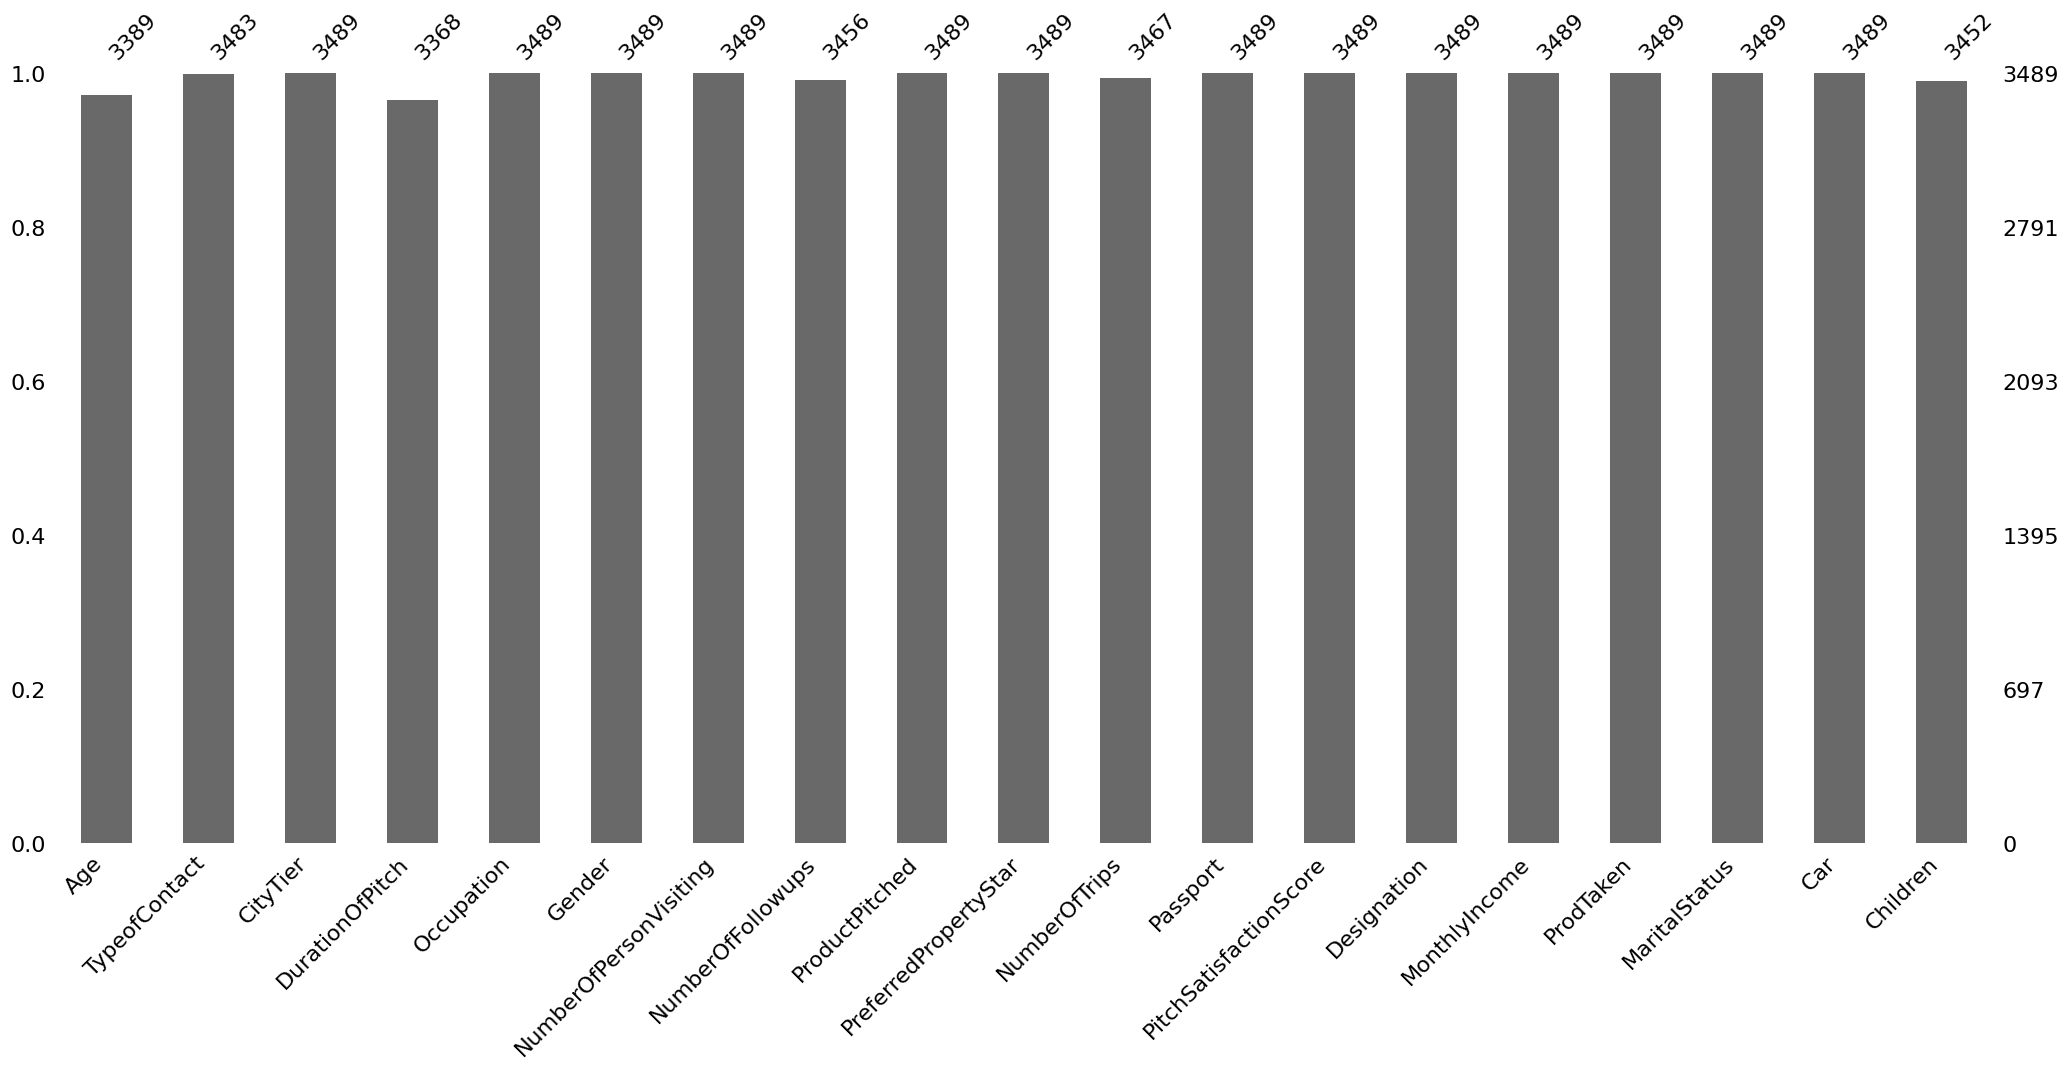

In [208]:
import missingno as msno

msno.bar(clean_data)

In [187]:
for cols in clean_data.columns:
    print(f'{cols} have {clean_data[cols].nunique()} unique values')

Age have 92 unique values
TypeofContact have 5 unique values
CityTier have 3 unique values
DurationOfPitch have 85 unique values
Occupation have 3 unique values
Gender have 2 unique values
NumberOfPersonVisiting have 4 unique values
NumberOfFollowups have 15 unique values
ProductPitched have 5 unique values
PreferredPropertyStar have 3 unique values
NumberOfTrips have 18 unique values
Passport have 2 unique values
PitchSatisfactionScore have 5 unique values
Designation have 5 unique values
MonthlyIncome have 2597 unique values
ProdTaken have 2 unique values
MaritalStatus have 2 unique values
Car have 2 unique values
Children have 11 unique values


In [188]:
X_train

,Age,TypeofContact,CityTier,DurationOfPitch,Occupation,Gender,NumberOfPersonVisiting,NumberOfFollowups,ProductPitched,PreferredPropertyStar,NumberOfTrips,Passport,PitchSatisfactionScore,Designation,MonthlyIncome,MaritalStatus,Car,Children
id,,,,,,,,,,,,,,,,,,
2741,14.0,1.0,0,31.0,1,0,3,4.0,2,0,4.0,0,3,4,0.325000,1,1,1.0
2687,16.0,1.0,0,30.0,2,0,2,2.0,0,0,2.0,0,3,1,0.261100,1,0,2.0
384,16.0,1.0,0,24.0,1,1,2,5.0,3,0,4.0,1,0,3,0.650000,1,1,2.0
1417,37.0,1.0,2,26.0,1,1,2,4.0,3,0,1.0,1,1,3,0.418113,1,1,2.0
1745,28.0,1.0,1,30.0,2,1,3,4.0,2,0,7.0,0,2,4,0.824688,1,0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
435,14.0,1.0,1,27.0,2,0,2,5.0,0,0,0.0,0,0,1,0.161163,1,0,2.0
2902,13.0,0.0,0,4.0,1,1,1,3.0,0,1,6.0,0,1,3,0.381775,0,1,1.0
1216,23.0,0.0,1,31.0,1,1,1,4.0,1,0,4.0,0,1,2,0.399138,1,1,1.0


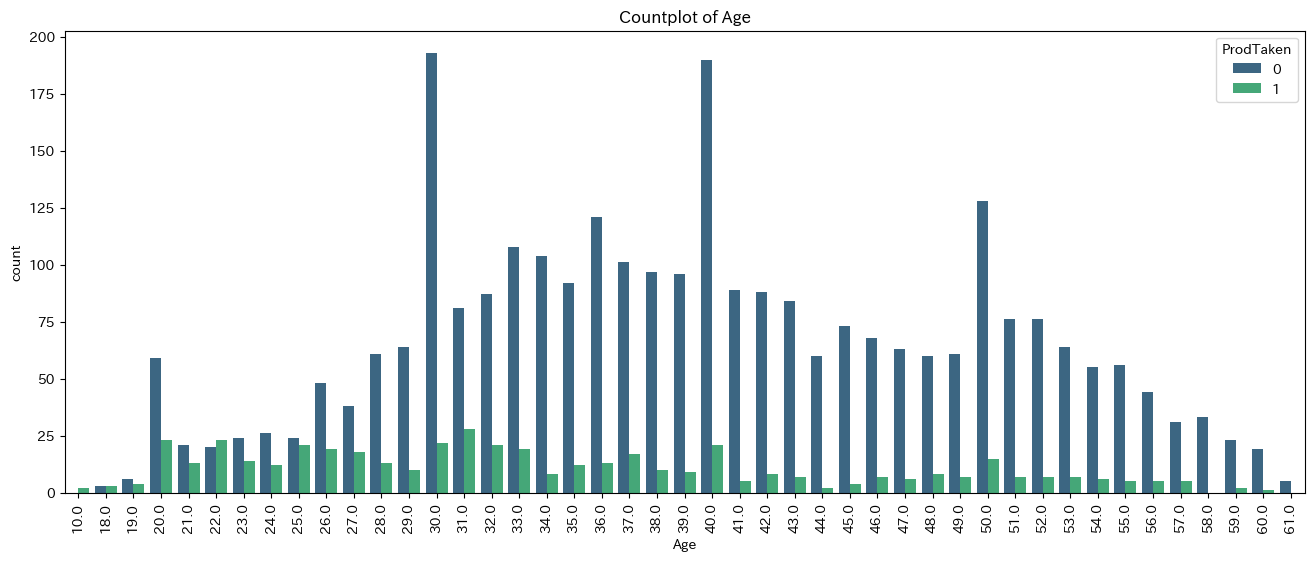

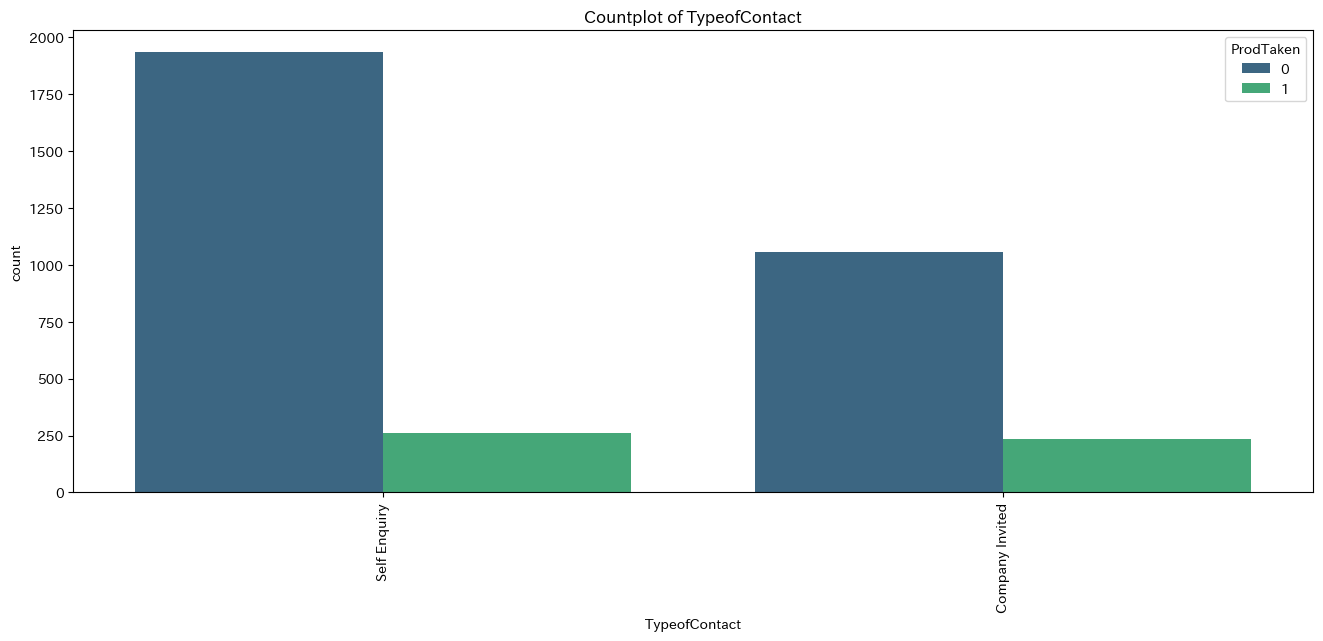

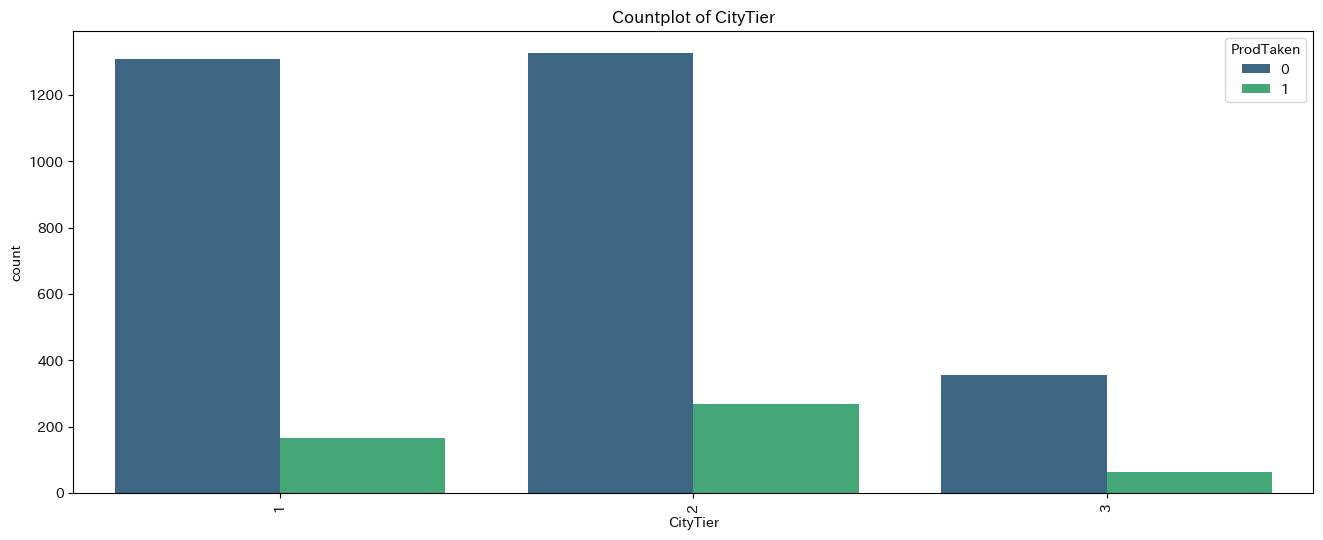

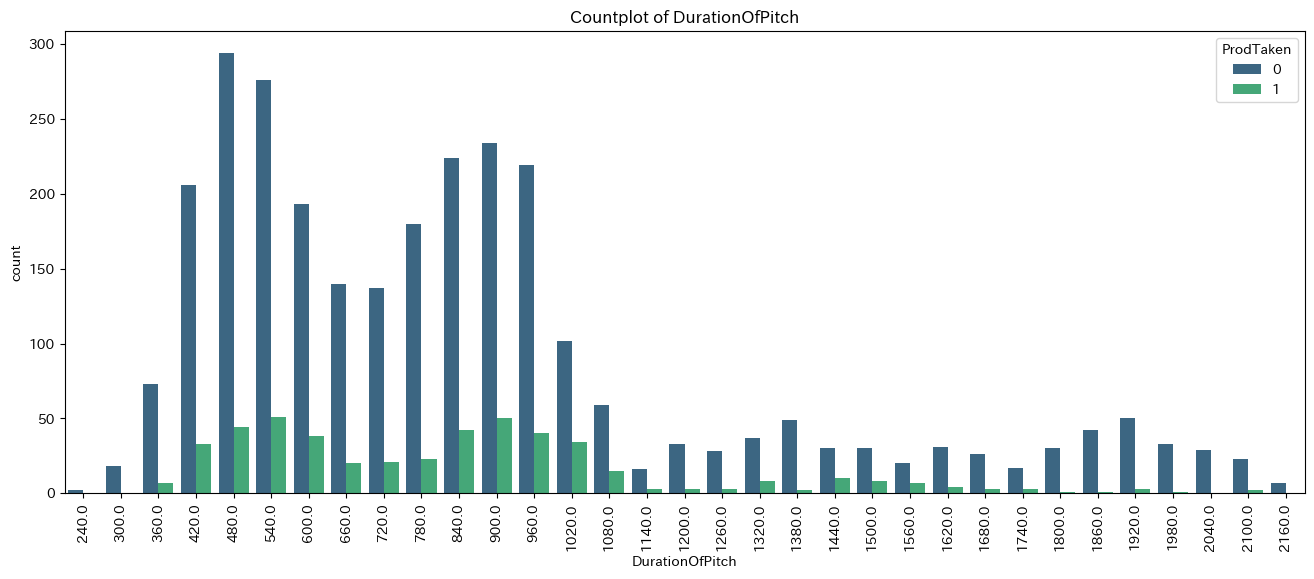

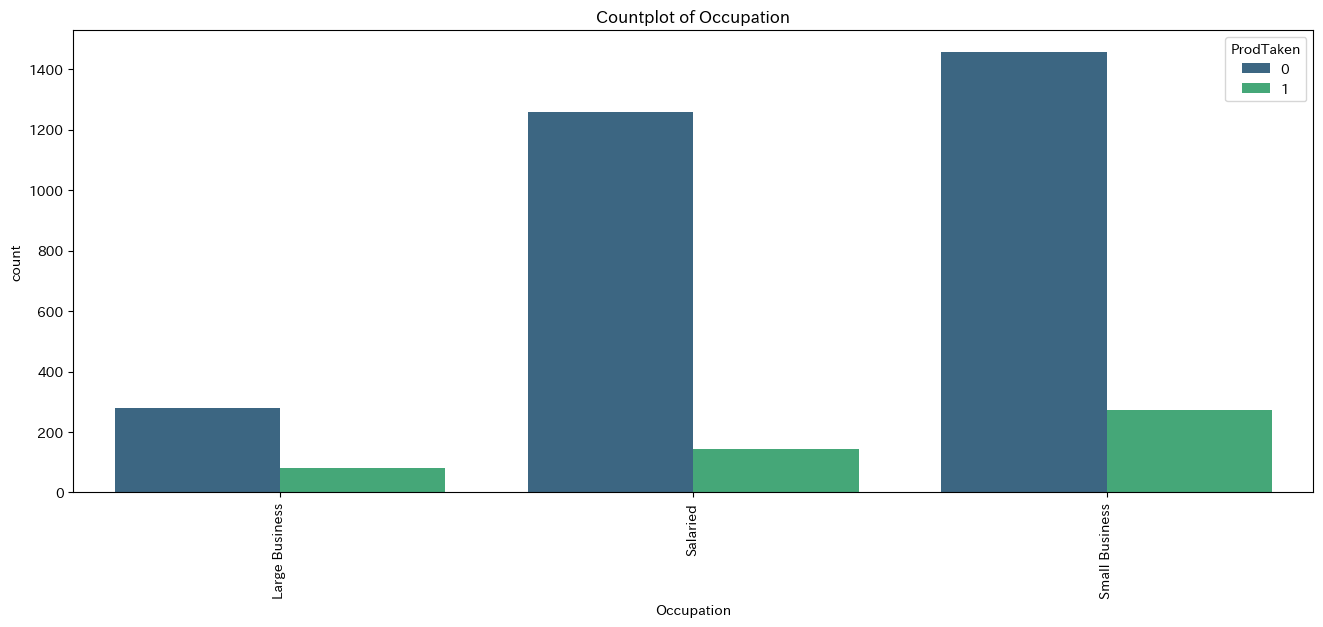

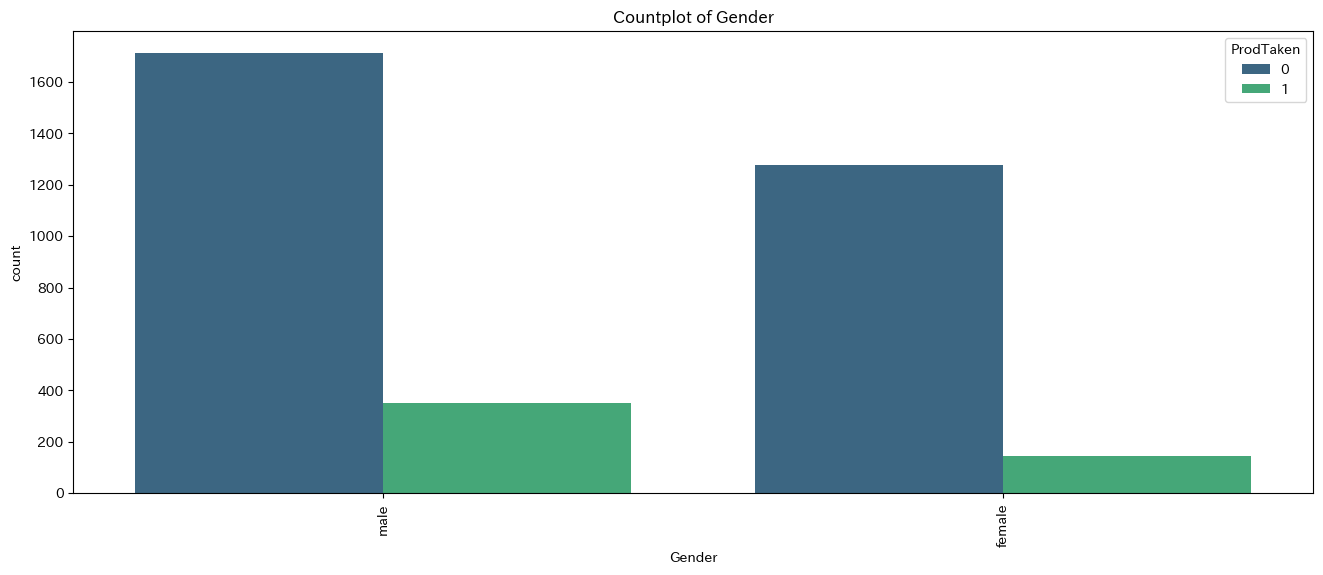

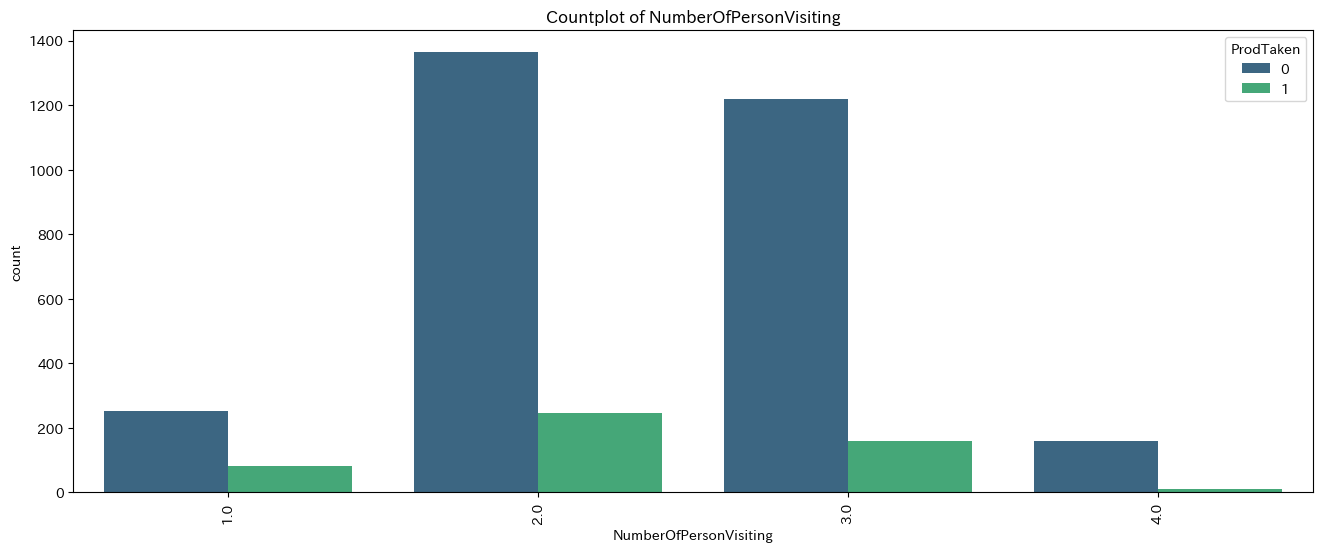

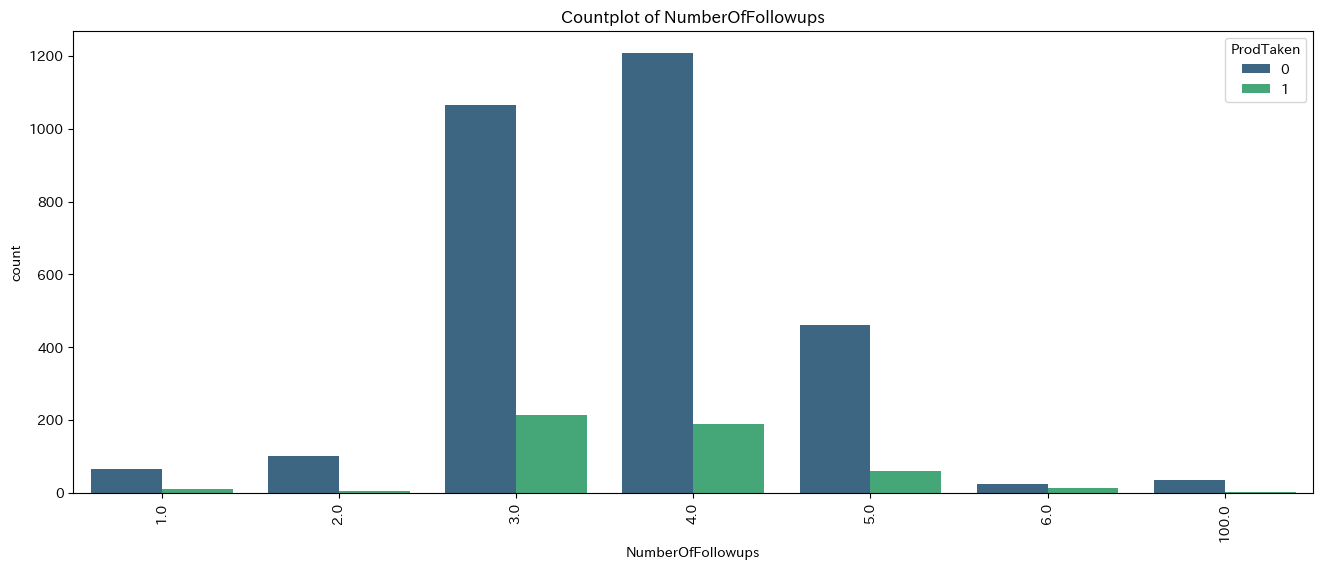

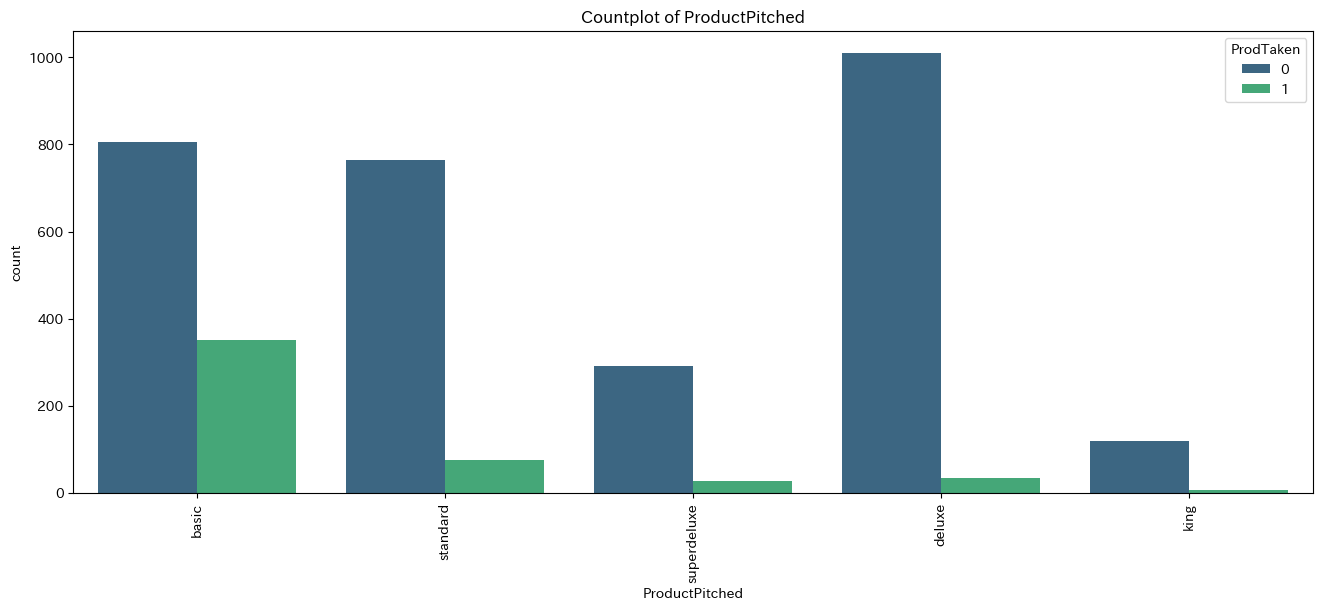

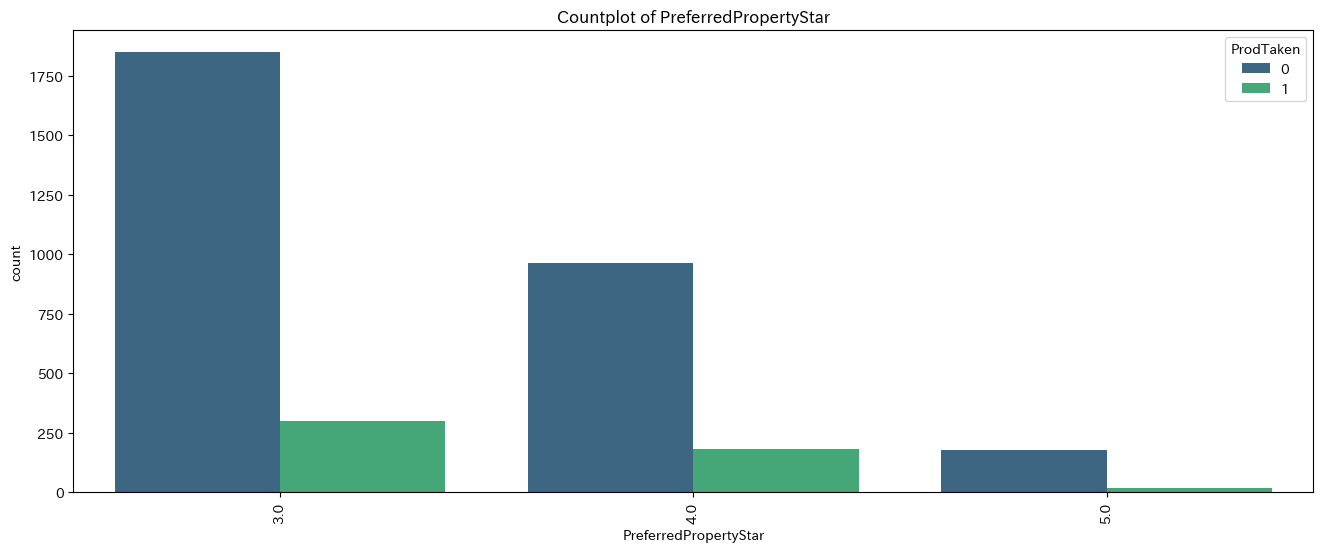

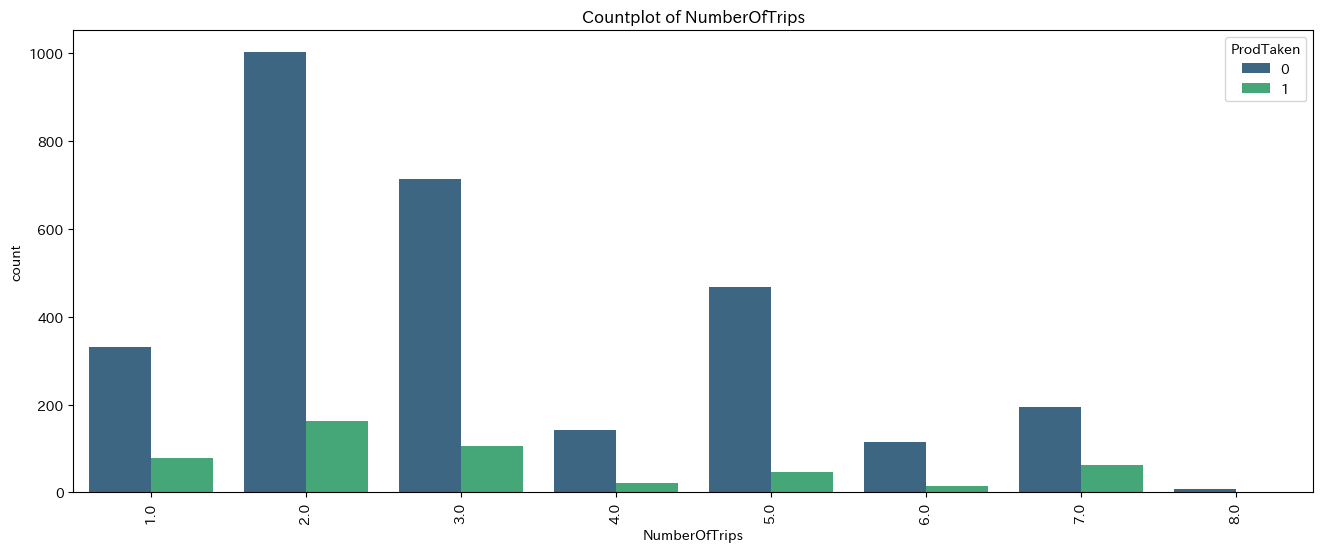

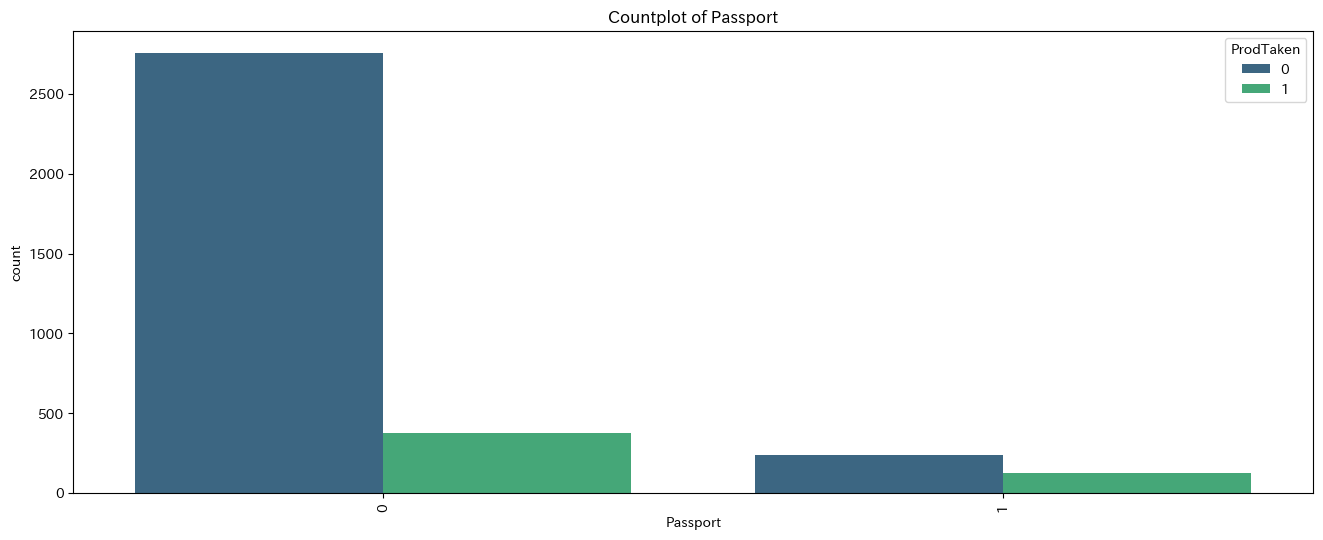

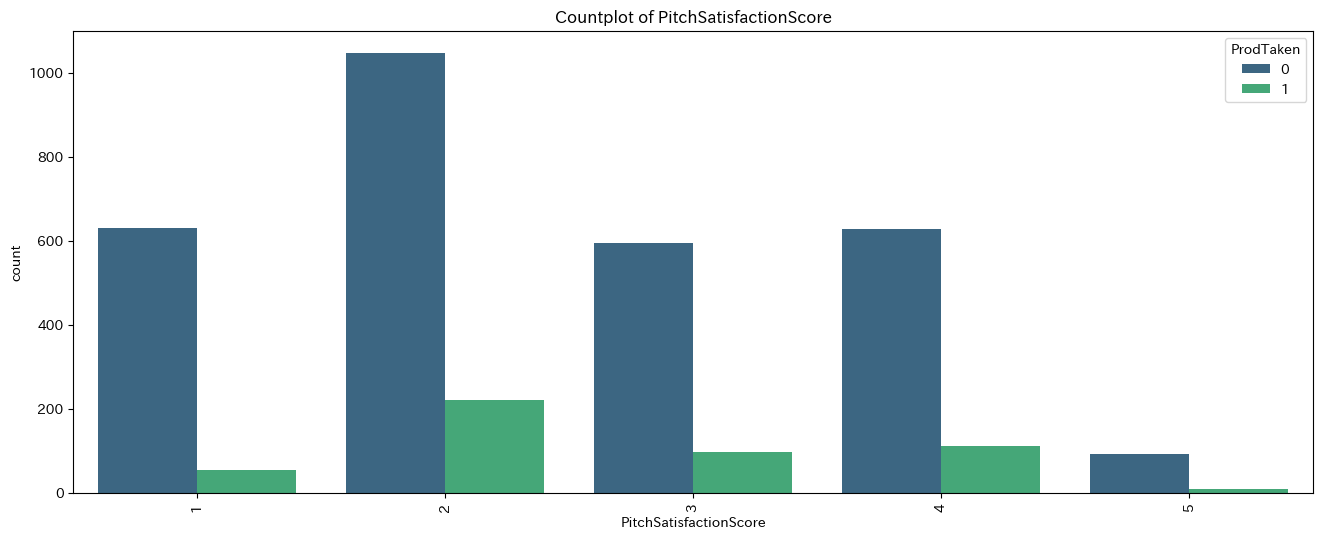

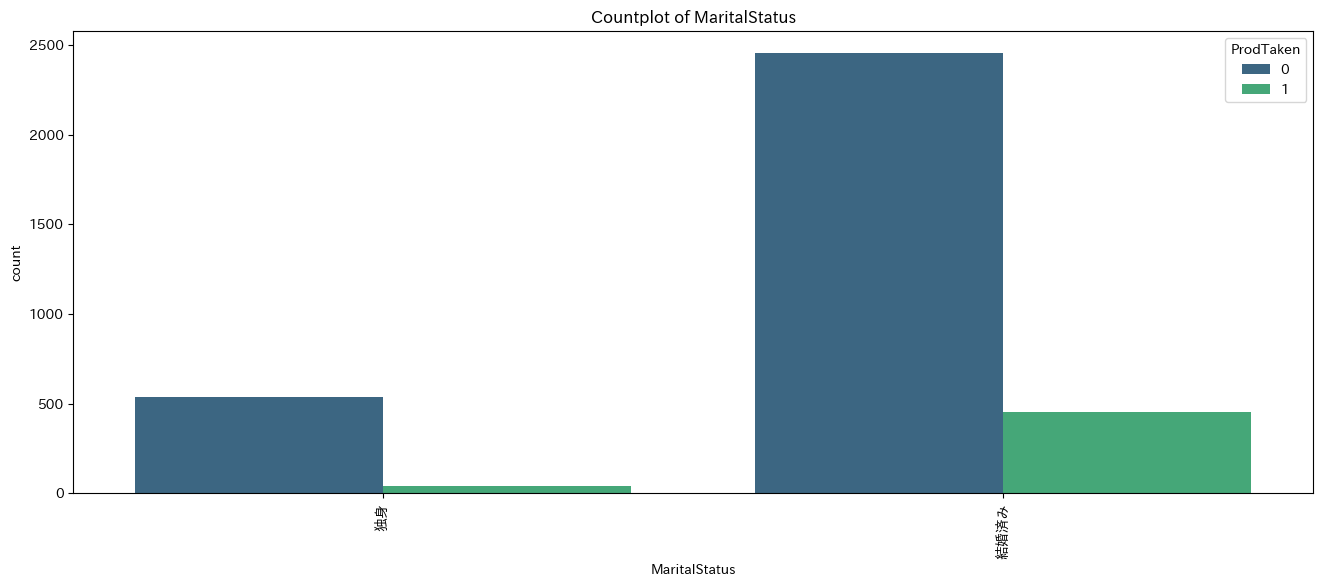

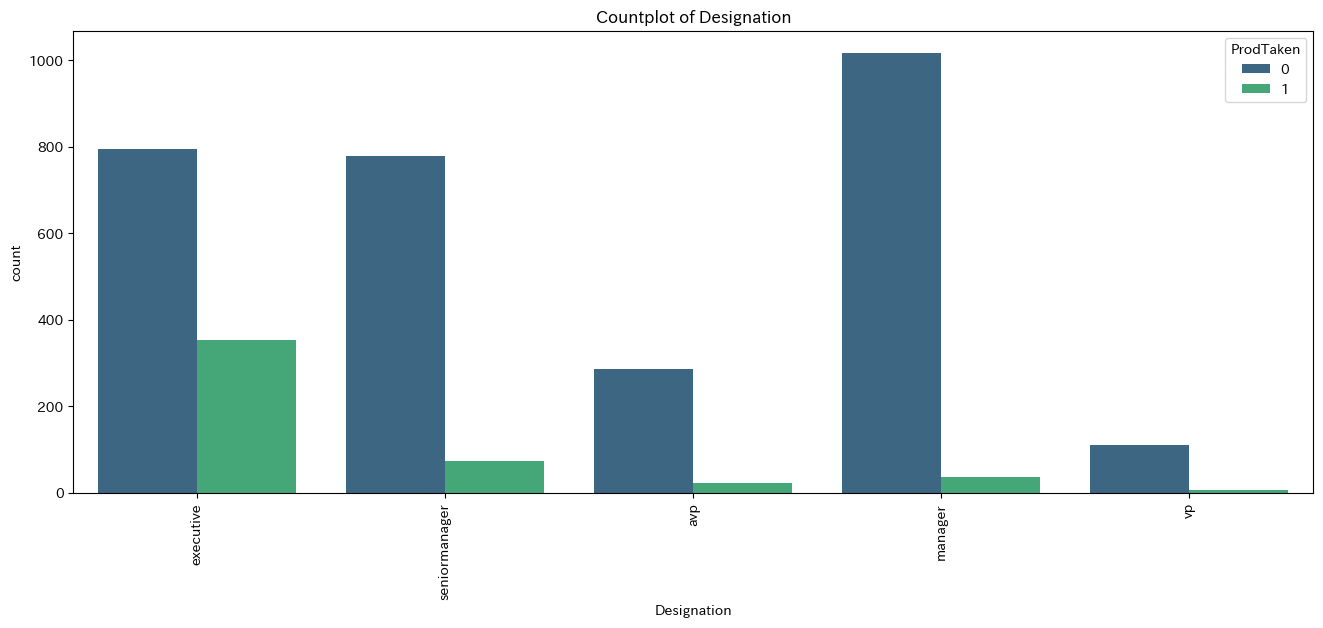

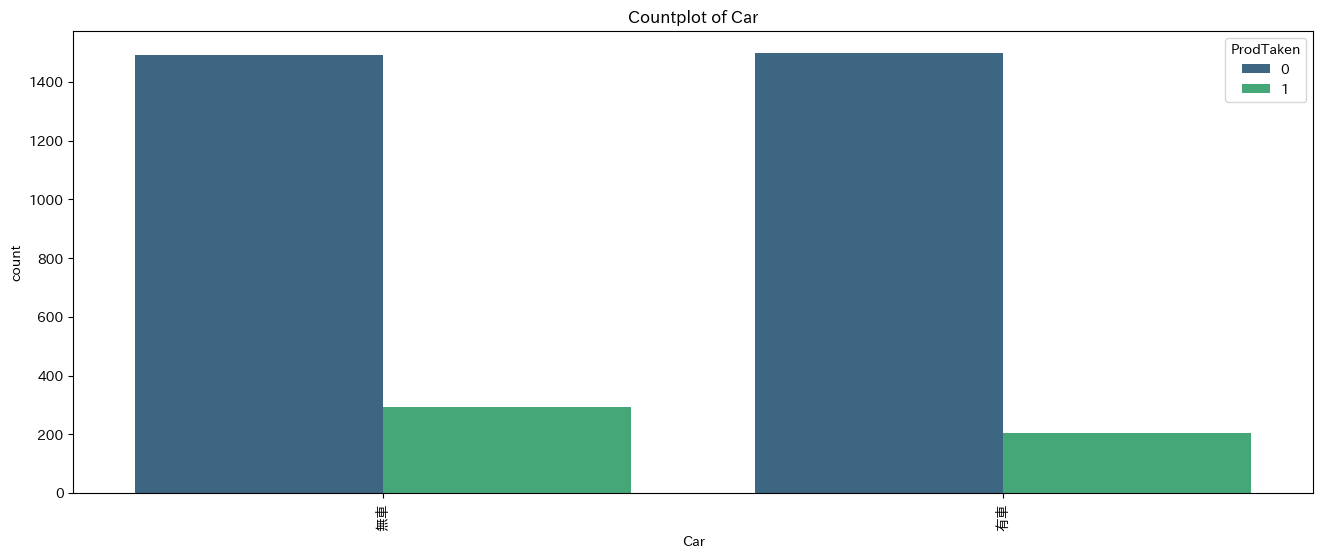

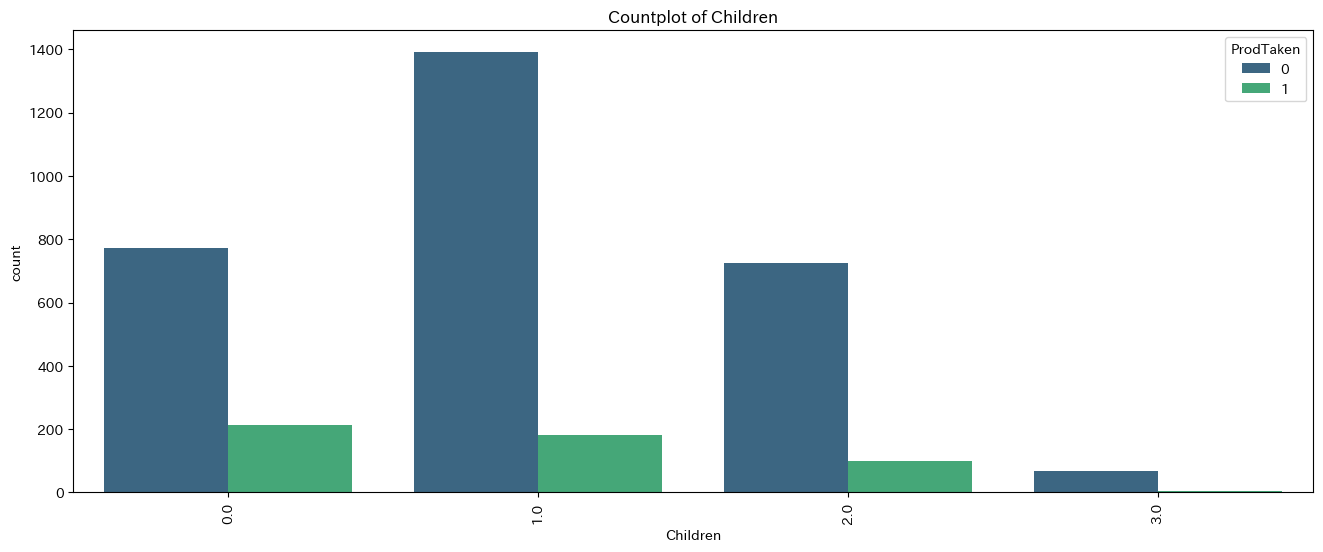

In [ ]:
import japanize_matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

for cat_col in categorical_columns:
    plt.figure(figsize=(16, 6))
    plt.title(f'Countplot of {cat_col}')
    sns.countplot(data=clean_data, x=cat_col, hue=y, palette='viridis')
    plt.xticks(rotation=90)
    plt.show()

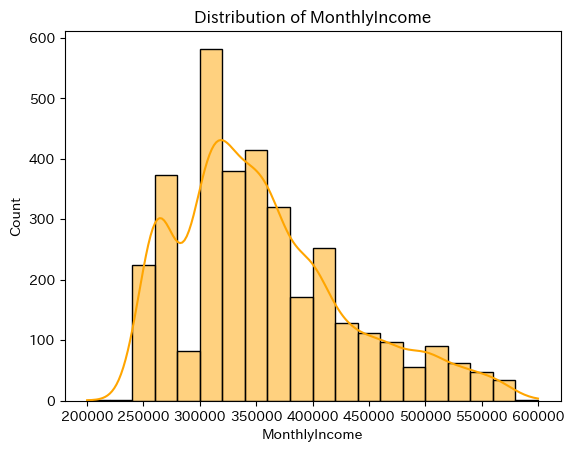

In [ ]:
for num_col in numerical_columns:
    plt.title(f'Distribution of {num_col}')
    sns.histplot(data=clean_data, x=num_col, bins=20, color='orange', kde=True)
    plt.show()

# Cat

In [ ]:
# X_train_cat = pipeline_cat.fit_transform(X_train, y_train)
# X_valid_cat = pipeline_cat.fit_transform(X_valid, y_valid)
# test_df_cat = pipeline_cat.fit_transform(test_df)

In [ ]:
# categorical_columns = [x + 1 for x in range(17)]

In [195]:
from catboost import Pool, CatBoostClassifier
import catboost as cb
from sklearn.metrics import roc_auc_score

train_pool = Pool(X_train, y_train, cat_features=categorical_columns)
valid_pool = Pool(X_valid, y_valid, cat_features=categorical_columns)

def objective(trial):
    param = {
        "random_state": 714,
        "loss_function": "Logloss",
        "objective": "Logloss",
        "silent": True,
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical(
            "bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]
        ),
        'od_type': trial.suggest_categorical('od_type', ['IncToDec', 'Iter']),
        'od_wait' :trial.suggest_int('od_wait', 10, 50),
        'iterations': trial.suggest_int('iterations', 500, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 1.0),
        'depth': trial.suggest_int('depth', 5, 14),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-4, 10.0),
        'random_strength': trial.suggest_int('random_strength', 0, 100),
        'border_count': trial.suggest_int('border_count', 1, 128),
    }

    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_int('bagging_temperature', 0, 10)
    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_float("subsample", 0.1, 1)

    gbm = cb.CatBoostClassifier(**param)

    gbm.fit(train_pool, eval_set=valid_pool, verbose=0, early_stopping_rounds=100)

    y_pred_proba = gbm.predict_proba(X_valid)[:, 1]
    auc_score = roc_auc_score(y_valid, y_pred_proba)

    return auc_score

In [196]:
import optuna

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=150)

[I 2024-08-10 10:14:20,460] A new study created in memory with name: no-name-fc053ee0-7877-4b25-b53b-83026658814e
[I 2024-08-10 10:14:26,754] Trial 0 finished with value: 0.7977510294583465 and parameters: {'colsample_bylevel': 0.08116174976357633, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'od_type': 'IncToDec', 'od_wait': 45, 'iterations': 964, 'learning_rate': 0.8701551726741806, 'depth': 10, 'l2_leaf_reg': 8.641083154021409, 'random_strength': 78, 'border_count': 47, 'subsample': 0.9189534155644267}. Best is trial 0 with value: 0.7977510294583465.
[I 2024-08-10 10:14:27,551] Trial 1 finished with value: 0.7676987646499841 and parameters: {'colsample_bylevel': 0.020259041794230583, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'od_type': 'Iter', 'od_wait': 50, 'iterations': 500, 'learning_rate': 0.9990920558346129, 'depth': 7, 'l2_leaf_reg': 2.0456564454000525, 'random_strength': 61, 'border_count': 110, 'bagging_temperature': 5}. Best is trial 0 with val

In [198]:
study.best_params

params = {'colsample_bylevel': 0.03761754348059537,
 'boosting_type': 'Plain',
 'bootstrap_type': 'MVS',
 'od_type': 'IncToDec',
 'od_wait': 49,
 'iterations': 827,
 'learning_rate': 0.12122297450004564,
 'depth': 6,
 'l2_leaf_reg': 8.822652665568123,
 'random_strength': 54,
 'border_count': 45}

In [209]:
import catboost as cb
from catboost import Pool

cat_model = cb.CatBoostClassifier(random_state=714,
                                  eval_metric='AUC',)

valid_set = Pool(data=X_valid,
                  label=y_valid,
                  cat_features=categorical_columns
                  )


cat_model.fit(X_train,
               y_train,
               cat_features=categorical_columns,
               eval_set=valid_set,
               silent=True)

CatBoostError: Invalid type for cat_feature[non-default value idx=5,feature_idx=0]=nan : cat_features must be integer or string, real number values and NaN values should be converted to string.

In [203]:
from sklearn.metrics import roc_auc_score

y_pred_proba = cat_model.predict_proba(X_valid)[:, 1]
auc_score = roc_auc_score(y_valid, y_pred_proba)
print(f'ROC-AUC Score: {auc_score}')

ROC-AUC Score: 0.8288129553373456


In [204]:
y_pred_proba = cat_model.predict_proba(clean_data_test)
result = pd.DataFrame({'id': test_df.index, 'ProdTaken': y_pred_proba[:, 1]})
result.to_csv('submission.csv', header=None, index=False)